In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


In [35]:
# Equations / functions

# Peterlin function
def peterlin(sigma, L2=50.0): #L2 is Length squared, see week 8 meeting notes in lab book
    tr_sigma = np.trace(sigma) #np.trace returns the sum of the diagonal of a matrix
    return (L2 - 3.0) / (L2 - tr_sigma)

# Upper-convected derivative
# ∇σ = dσ/dt - (σ·∇v + (∇v)^T·σ)
def upper_convected(t, sigma, grad):
    return - (sigma @ grad + grad.T @ sigma)

# System of ODEs for sigma_u and sigma_b (both 3x3 -> flattened 18 variables)
def rhs(t, y):
    sigma_u = y[:9].reshape((3, 3))
    sigma_b = y[9:].reshape((3, 3))
    grad = grad_v(t)

    # Compute Peterlin factors
    fP_u = peterlin(sigma_u)
    fP_b = peterlin(sigma_b)
    if fP_u <=0 or fP_b <=0:
        print(f'Error, sigma_b = {sigma_b} and trace_sigma_b = {np.trace(sigma_b)} and fP_b = {fP_b} at time = {t}')
    
    #fP_u = 1
    #fP_b = 1

    # Eqn for sigma_u
    dsigma_u_dt = n * kB * T * ( grad + grad.T ) \
                   - ((1 + k_plus * tau_u) * fP_u * sigma_u \
                   + k_minus * tau_u * fP_b * sigma_b \
                   - tau_u * upper_convected(t, sigma_u, grad))/tau_u

    dsigma_b_dt = n * kB * T * ( grad + grad.T ) \
                   - ((1 + k_minus * tau_b) * fP_b * sigma_b \
                   + k_plus * tau_b * fP_u * sigma_u \
                   - tau_b * upper_convected(t, sigma_b, grad))/tau_b

    return np.concatenate([dsigma_u_dt.flatten(), dsigma_b_dt.flatten()])

# Sticky Dumbbell For Constant Extensional Flow

Sigma_u at t=1000:
[[ 28.35749644   0.           0.        ]
 [  0.         -10.29389733   0.        ]
 [  0.           0.         -10.29389733]]


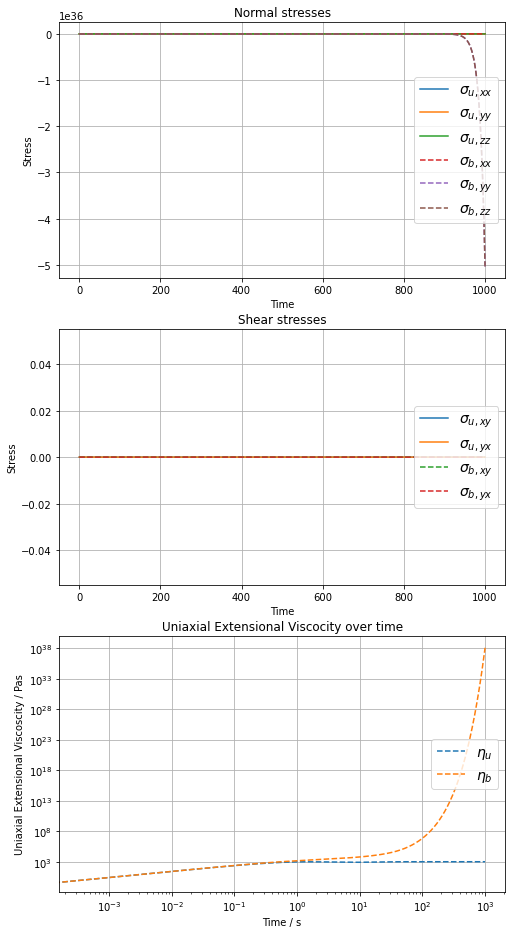

In [36]:
# Define parameters

epsilon_prime = 0.04 #So dε/dt or ε' however you wish to write it. Where ε is the 
k_plus = 1.0 #binding rate
k_minus = 0.5 #unbinding rate
tau_u = 1.0
tau_b = 10.0
n = 1.0
kB = 1.0 #Boltzmann constant - 1.380649 × 10⁻²³
T = 273.15+150 #in kelvin

# Velocity gradient tensor 
def grad_v(t):
    return np.array([[2*(epsilon_prime), 0.0, 0.0], #See Theoretical rheo-physics of silk, Journal of Rheology paper, eqn 12
                     [0.0, -epsilon_prime, 0.0],
                     [0.0, 0.0, -epsilon_prime]])

# Initial conditions (identity tensors)
sigma_u0 = np.eye(3)
sigma_b0 = np.eye(3)
y0 = np.concatenate([sigma_u0.flatten(), sigma_b0.flatten()])


# Time span
t_span = (0, 1000)
t_eval = np.linspace(t_span[0], t_span[1], 3000000)


# Solve
sol = solve_ivp(rhs, t_span, y0, t_eval=t_eval, method='RK45')


# Extract solutions
sigma_u_sol = sol.y[:9, :].T.reshape(-1, 3, 3)
sigma_b_sol = sol.y[9:, :].T.reshape(-1, 3, 3)


# Example: print sigma_u at final time
print("Sigma_u at t=1000:")
print(sigma_u_sol[-1])

# ---- Plotting ----
t = sol.t

fig, axs = plt.subplots(3, 1, figsize=(8, 16))

# Normal stresses (xx, yy, zz from both sigma_u and sigma_b)
axs[0].plot(t, sigma_u_sol[:, 0, 0], label=r"$\sigma_{u,xx}$")
axs[0].plot(t, sigma_u_sol[:, 1, 1], label=r"$\sigma_{u,yy}$")
axs[0].plot(t, sigma_u_sol[:, 2, 2], label=r"$\sigma_{u,zz}$")
axs[0].plot(t, sigma_b_sol[:, 0, 0], '--', label=r"$\sigma_{b,xx}$")
axs[0].plot(t, sigma_b_sol[:, 1, 1], '--', label=r"$\sigma_{b,yy}$")
axs[0].plot(t, sigma_b_sol[:, 2, 2], '--', label=r"$\sigma_{b,zz}$")
axs[0].set_title("Normal stresses")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Stress")
axs[0].legend(fontsize=14, loc="center right")
axs[0].grid(True)

# Shear stresses (xy from both sigma_u and sigma_b, you can add yz, xz too)
axs[1].plot(t, sigma_u_sol[:, 0, 1], label=r"$\sigma_{u,xy}$")
axs[1].plot(t, sigma_u_sol[:, 1, 0], label=r"$\sigma_{u,yx}$")
axs[1].plot(t, sigma_b_sol[:, 0, 1], '--', label=r"$\sigma_{b,xy}$")
axs[1].plot(t, sigma_b_sol[:, 1, 0], '--', label=r"$\sigma_{b,yx}$")
#axs[1].plot(t, sigma_b_sol[:, 0, 1]+sigma_u_sol[:,0,1], '--', label="sigma total")
axs[1].set_title("Shear stresses")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Stress")
axs[1].legend(fontsize=14, loc="center right")
axs[1].grid(True)
#plt.tight_layout()
#plt.show()

uniaxial_ext_visc_u = (sigma_u_sol[:, 0, 0] - sigma_u_sol[:, 1, 1])/epsilon_prime
uniaxial_ext_visc_b = (sigma_b_sol[:, 0, 0] - sigma_b_sol[:, 1, 1])/epsilon_prime

# --- New plot: Stress vs Strain ---
axs[2].plot(t, uniaxial_ext_visc_u, '--', label=r"$\eta_{u}$")
axs[2].plot(t, uniaxial_ext_visc_b, '--', label=r"$\eta_{b}$")
axs[2].set_xlabel("Time / s")
axs[2].set_ylabel("Uniaxial Extensional Viscoscity / Pas")
axs[2].set_title("Uniaxial Extensional Viscocity over time")
axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].legend(fontsize=14, loc="center right")
axs[2].grid(True)
fig.savefig("ext_graphs_1&2&3_first_try.png", dpi=300, bbox_inches="tight")



# Sticky Dumbbell For Constant Shear

In [ ]:
# Define parameters

strain_rate = 0.001 #Strain-rate, γ'
k_plus = 1.0
k_minus = 0.5
tau_u = 1.0
tau_b = 10.0
n = 1.0
kB = 1.0 #Boltzmann constant - 1.380649 × 10⁻²³
T = 1.0 #in kelvin

# Velocity gradient tensor 
def grad_v(t):
    return np.array([[0.0, strain_rate, 0.0], #See Theoretical rheo-physics of silk, Journal of Rheology paper, eqn 12
                     [0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0]])

# Initial conditions (identity tensors)
sigma_u0 = np.eye(3)
sigma_b0 = np.eye(3)
y0 = np.concatenate([sigma_u0.flatten(), sigma_b0.flatten()])


# Time span
t_span = (0, 50)
t_eval = np.linspace(t_span[0], t_span[1], 3000000)


# Solve
sol = solve_ivp(rhs, t_span, y0, t_eval=t_eval, method='RK45')


# Extract solutions
sigma_u_sol = sol.y[:9, :].T.reshape(-1, 3, 3)
sigma_b_sol = sol.y[9:, :].T.reshape(-1, 3, 3)


# Example: print sigma_u at final time
print("Sigma_u at t=50:")
print(sigma_u_sol[-1])

# ---- Plotting ----
t = sol.t

fig, axs = plt.subplots(3, 1, figsize=(8, 16))

# Normal stresses (xx, yy, zz from both sigma_u and sigma_b)
axs[0].plot(t, sigma_u_sol[:, 0, 0], label=r"$\sigma_{u,xx}$")
axs[0].plot(t, sigma_u_sol[:, 1, 1], label=r"$\sigma_{u,yy}$")
axs[0].plot(t, sigma_u_sol[:, 2, 2], label=r"$\sigma_{u,zz}$")
axs[0].plot(t, sigma_b_sol[:, 0, 0], '--', label=r"$\sigma_{b,xx}$")
axs[0].plot(t, sigma_b_sol[:, 1, 1], '--', label=r"$\sigma_{b,yy}$")
axs[0].plot(t, sigma_b_sol[:, 2, 2], '--', label=r"$\sigma_{b,zz}$")
axs[0].set_title("Normal stresses")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Stress")
axs[0].legend(fontsize=14, loc="center right")
axs[0].grid(True)

# Shear stresses (xy from both sigma_u and sigma_b, you can add yz, xz too)
axs[1].plot(t, sigma_u_sol[:, 0, 1], label=r"$\sigma_{u,xy}$")
axs[1].plot(t, sigma_u_sol[:, 1, 0], label=r"$\sigma_{u,yx}$")
axs[1].plot(t, sigma_b_sol[:, 0, 1], '--', label=r"$\sigma_{b,xy}$")
axs[1].plot(t, sigma_b_sol[:, 1, 0], '--', label=r"$\sigma_{b,yx}$")
#axs[1].plot(t, sigma_b_sol[:, 0, 1]+sigma_u_sol[:,0,1], '--', label="sigma total")
axs[1].set_title("Shear stresses")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Stress")
axs[1].legend(fontsize=14, loc="center right")
axs[1].grid(True)
#plt.tight_layout()
#plt.show()

shear_visc_u = (sigma_u_sol[:, 0, 1])/strain_rate
shear_visc_b = (sigma_b_sol[:, 0, 1])/strain_rate

# --- New plot: Stress vs Strain ---
axs[2].plot(t, shear_visc_u, '--', label=r"$\eta_{u}$")
axs[2].plot(t, shear_visc_b, '--', label=r"$\eta_{b}$")
axs[2].set_xlabel("Time / s")
axs[2].set_ylabel("Shear Viscoscity / Pas")
axs[2].set_title("Shear Viscocity over time")
axs[2].legend(fontsize=14, loc="center right")
axs[2].grid(True)
fig.savefig("shear_graphs_1&2&3_first_try.png", dpi=300, bbox_inches="tight")



# OG code


Sigma_u at t=10:
[[ 0.82840453 -1.4139141   0.        ]
 [-1.4139141   7.00048719  0.        ]
 [ 0.          0.          0.82840453]]


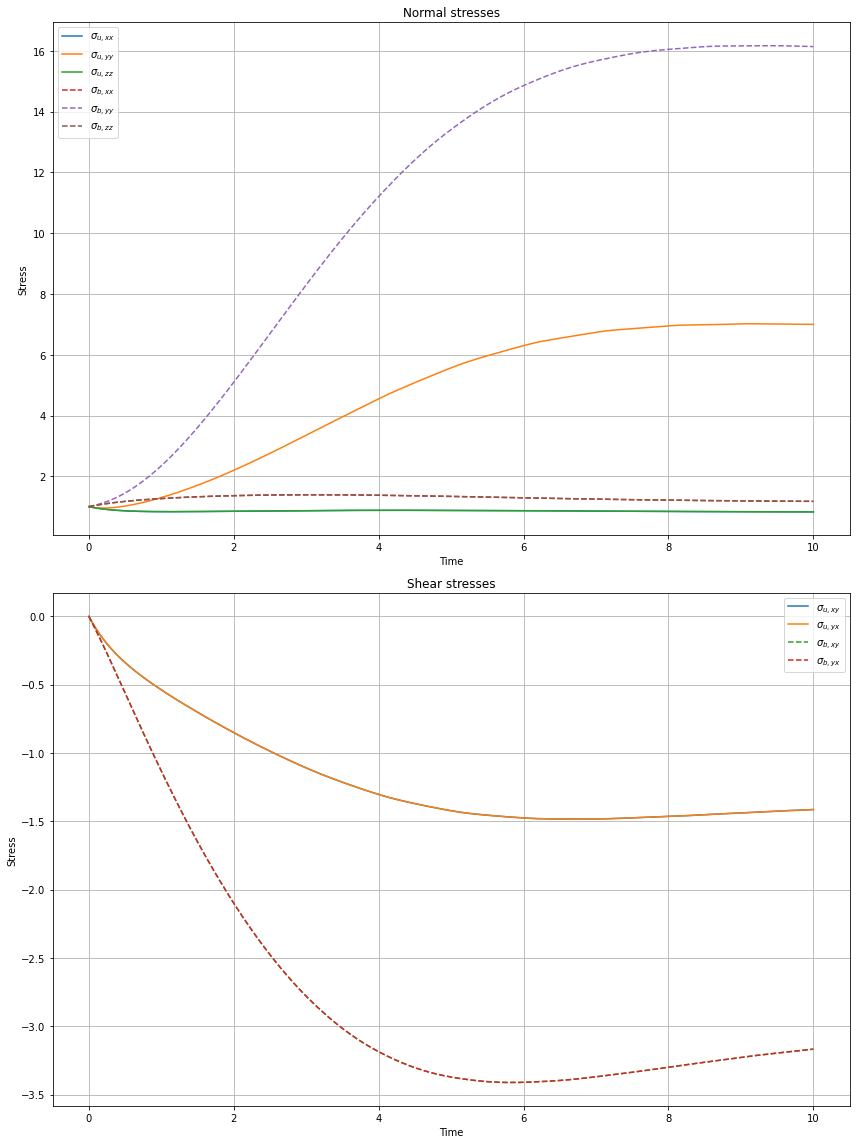

In [5]:
# Define parameters (set your own values)
k_plus = 1.0
k_minus = 0.5
tau_u = 1.0
tau_b = 10.0
n = 1.0
kB = 1.0
T = 1.0

# Peterlin function
def peterlin(sigma, L2=50.0): #What is L2?
    tr_sigma = np.trace(sigma) #np.trace returns the sum of the diagonal of a matrix
    return (L2 - 3.0) / (L2 - tr_sigma)
    
# Velocity gradient tensor (example: simple shear)
def grad_v(t):
    return np.array([[0.0, 1.0, 0.0],
                     [0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0]])


# Upper-convected derivative
# ∇σ = dσ/dt - (σ·∇v + (∇v)^T·σ)
def upper_convected(t, sigma, grad): #doing a matrix.T gives transpose of the matrix
    return - (sigma @ grad + grad.T @ sigma) #@ sign is used for matrix multiplication


# System of ODEs for sigma_u and sigma_b (both 3x3 -> flattened 18 variables)
def rhs(t, y): #y is a flat 18 variable 1D array which contains sigma_u & b values
    sigma_u = y[:9].reshape((3, 3)) #First 9 values correspond to sigma_u tensor
    sigma_b = y[9:].reshape((3, 3)) #Second set of 9 values correspond to sigma_b tensor
    grad = grad_v(t)
    
    # Compute Peterlin factors
    fP_u = peterlin(sigma_u)
    fP_b = peterlin(sigma_b)

    # Eqn for sigma_u
    dsigma_u_dt = (n * kB * T * np.eye(3)
                   - (1 + k_plus * tau_u) * fP_u * sigma_u
                   + k_minus * tau_u * fP_b * sigma_b
                   ) / tau_u + upper_convected(t, sigma_u, grad)

    # Eqn for sigma_b
    dsigma_b_dt = (n * kB * T * np.eye(3)
                   - (1 + k_minus * tau_b) * fP_b * sigma_b
                   + k_plus * tau_b * fP_u * sigma_u
                   ) / tau_b + upper_convected(t, sigma_b, grad)

    return np.concatenate([dsigma_u_dt.flatten(), dsigma_b_dt.flatten()])


# Initial conditions (identity tensors)
sigma_u0 = np.eye(3)
sigma_b0 = np.eye(3)
y0 = np.concatenate([sigma_u0.flatten(), sigma_b0.flatten()])


# Time span
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], 200)


# Solve
sol = solve_ivp(rhs, t_span, y0, t_eval=t_eval, method='RK45')


# Extract solutions
sigma_u_sol = sol.y[:9, :].T.reshape(-1, 3, 3)
sigma_b_sol = sol.y[9:, :].T.reshape(-1, 3, 3)


# Example: print sigma_u at final time
print("Sigma_u at t=10:")
print(sigma_u_sol[-1])

# ---- Plotting ----
t = sol.t

fig, axs = plt.subplots(2, 1, figsize=(12, 16))

# Normal stresses (xx, yy, zz from both sigma_u and sigma_b)
axs[0].plot(t, sigma_u_sol[:, 0, 0], label=r"$\sigma_{u,xx}$")
axs[0].plot(t, sigma_u_sol[:, 1, 1], label=r"$\sigma_{u,yy}$")
axs[0].plot(t, sigma_u_sol[:, 2, 2], label=r"$\sigma_{u,zz}$")
axs[0].plot(t, sigma_b_sol[:, 0, 0], '--', label=r"$\sigma_{b,xx}$")
axs[0].plot(t, sigma_b_sol[:, 1, 1], '--', label=r"$\sigma_{b,yy}$")
axs[0].plot(t, sigma_b_sol[:, 2, 2], '--', label=r"$\sigma_{b,zz}$")
axs[0].set_title("Normal stresses")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Stress")
axs[0].legend()
axs[0].grid(True)

# Shear stresses (xy from both sigma_u and sigma_b, you can add yz, xz too)
axs[1].plot(t, sigma_u_sol[:, 0, 1], label=r"$\sigma_{u,xy}$")
axs[1].plot(t, sigma_u_sol[:, 1, 0], label=r"$\sigma_{u,yx}$")
axs[1].plot(t, sigma_b_sol[:, 0, 1], '--', label=r"$\sigma_{b,xy}$")
axs[1].plot(t, sigma_b_sol[:, 1, 0], '--', label=r"$\sigma_{b,yx}$")
axs[1].set_title("Shear stresses")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Stress")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()



# Sticky Dumbell Oscillatory code

Sigma_u at t=10:
[[ 7.50670936e-28  6.06719381e+01  0.00000000e+00]
 [ 2.72958977e-30 -1.07886279e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  7.50670936e-28]]


C:\Users\cronk\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


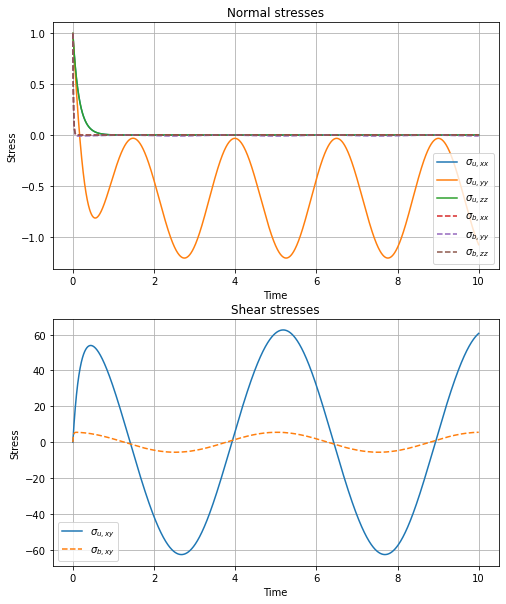

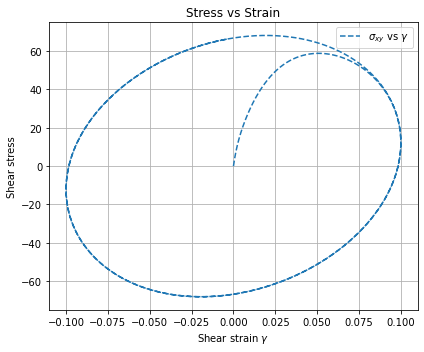

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


# Define parameters

kB = 1.0
T = 1.0


tau_u = 0.149160
tau_b = 0.013278
k_plus = 0.010000
k_minus = 0.010000
n = 3149.598944

Amplitude = 0.1
Frequency=1.253

# Peterlin function
def peterlin(sigma, L2=50.0): #L2 is Length squared, see week 8 meeting notes in lab book
    tr_sigma = np.trace(sigma) #np.trace returns the sum of the diagonal of a matrix
    return (L2 - 3.0) / (L2 - tr_sigma)

# Velocity gradient tensor (example: simple shear)
def grad_v(t):
    return np.array([[0.0, Frequency*Amplitude*np.cos(Frequency*t), 0.0],
                     [0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0]])


# Upper-convected derivative
# ∇σ = dσ/dt - (σ·∇v + (∇v)^T·σ)
def upper_convected(t, sigma, grad):
    return - (sigma @ grad + grad.T @ sigma)


# System of ODEs for sigma_u and sigma_b (both 3x3 -> flattened 18 variables)
def rhs(t, y):
    sigma_u = y[:9].reshape((3, 3))
    sigma_b = y[9:].reshape((3, 3))
    grad = grad_v(t)

    # Compute Peterlin factors
    fP_u = peterlin(sigma_u)
    fP_b = peterlin(sigma_b)
    #fP_u = 1
    #fP_b = 1

    # Eqn for sigma_u
    dsigma_u_dt = n * kB * T * grad \
                   - ((1 + k_plus * tau_u) * fP_u * sigma_u \
                   + k_minus * tau_u * fP_b * sigma_b \
                   - tau_u * upper_convected(t, sigma_u, grad))/tau_u

    dsigma_b_dt = n * kB * T * grad \
                   - ((1 + k_minus * tau_b) * fP_b * sigma_b \
                   + k_plus * tau_b * fP_u * sigma_u \
                   - tau_b * upper_convected(t, sigma_b, grad))/tau_b

    return np.concatenate([dsigma_u_dt.flatten(), dsigma_b_dt.flatten()])


# Initial conditions (identity tensors)
sigma_u0 = np.eye(3)
sigma_b0 = np.eye(3)
y0 = np.concatenate([sigma_u0.flatten(), sigma_b0.flatten()])


# Time span
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], 3000000)


# Solve
sol = solve_ivp(rhs, t_span, y0, t_eval=t_eval, method='RK45')


# Extract solutions
sigma_u_sol = sol.y[:9, :].T.reshape(-1, 3, 3)
sigma_b_sol = sol.y[9:, :].T.reshape(-1, 3, 3)


# Example: print sigma_u at final time
print("Sigma_u at t=10:")
print(sigma_u_sol[-1])

# ---- Plotting ----
t = sol.t

fig, axs = plt.subplots(2, 1, figsize=(8, 10))

# Normal stresses (xx, yy, zz from both sigma_u and sigma_b)
axs[0].plot(t, sigma_u_sol[:, 0, 0], label=r"$\sigma_{u,xx}$")
axs[0].plot(t, sigma_u_sol[:, 1, 1], label=r"$\sigma_{u,yy}$")
axs[0].plot(t, sigma_u_sol[:, 2, 2], label=r"$\sigma_{u,zz}$")
axs[0].plot(t, sigma_b_sol[:, 0, 0], '--', label=r"$\sigma_{b,xx}$")
axs[0].plot(t, sigma_b_sol[:, 1, 1], '--', label=r"$\sigma_{b,yy}$")
axs[0].plot(t, sigma_b_sol[:, 2, 2], '--', label=r"$\sigma_{b,zz}$")
axs[0].set_title("Normal stresses")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Stress")
axs[0].legend()
axs[0].grid(True)

# Shear stresses (xy from both sigma_u and sigma_b, you can add yz, xz too)
axs[1].plot(t, sigma_u_sol[:, 0, 1], label=r"$\sigma_{u,xy}$")
#axs[1].plot(t, sigma_u_sol[:, 1, 0], label=r"$\sigma_{u,yx}$")
axs[1].plot(t, sigma_b_sol[:, 0, 1], '--', label=r"$\sigma_{b,xy}$")
#axs[1].plot(t, sigma_b_sol[:, 1, 0], '--', label=r"$\sigma_{b,yx}$")
#axs[1].plot(t, sigma_b_sol[:, 0, 1]+sigma_u_sol[:,0,1], '--', label="sigma total")
axs[1].set_title("Shear stresses")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Stress")
axs[1].legend()
axs[1].grid(True)
#plt.tight_layout()
#plt.show()

# --- Compute strain history ---
gamma = (Amplitude) * np.sin(Frequency * t)  # oscillatory strain
gamma_dot = Amplitude * np.cos(Frequency * t)            # strain rate

# --- New plot: Stress vs Strain ---
plt.figure(figsize=(6,5))
#plt.plot(gamma, sigma_u_sol[:, 0, 1], label=r"$\sigma_{u,xy}$ vs $\gamma$")
#plt.plot(gamma, sigma_b_sol[:, 0, 1], '--', label=r"$\sigma_{b,xy}$ vs $\gamma$")
plt.plot(gamma, sigma_u_sol[:, 0, 1]+sigma_b_sol[:, 0, 1], '--', label=r"$\sigma_{xy}$ vs $\gamma$")
plt.xlabel("Shear strain $\gamma$")
plt.ylabel("Shear stress")
plt.title("Stress vs Strain")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()